In [1]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/rnaveiro/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the dataset

In [23]:
boston = fetch_openml(name="boston", version=1, as_frame=False)
X = boston.data
y = boston.target

# Scale features

In [24]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_interactions)

# Train-test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Bayesian Linear Regression with Horseshoe Prior

In [26]:
def model(X, y=None):
    n_features = X.shape[1]
    local_shrinkage = numpyro.sample('local_shrinkage', dist.HalfCauchy(scale=1.0).expand([n_features]).to_event(1))
    global_shrinkage = numpyro.sample('global_shrinkage', dist.HalfCauchy(scale=1.0))
    tau = global_shrinkage * local_shrinkage
    beta = numpyro.sample('beta', dist.Normal(0, tau))
    intercept = numpyro.sample('intercept', dist.Normal(0, 1))
    mu = jnp.dot(X, beta) + intercept
    sigma = numpyro.sample('sigma', dist.HalfCauchy(scale=1.0))
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=y)

## MCMC

In [27]:
num_samples = 1000
num_warmup = 500
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, progress_bar=True)
mcmc.run(jax.random.PRNGKey(0), X_train, y_train)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:14<00:00, 101.02it/s, 511 steps of size 6.25e-03. acc. prob=0.86] 



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
            beta[0]     -0.97      2.59     -0.18     -5.34      1.87    132.58      1.00
            beta[1]     -1.16      2.26     -0.43     -5.09      1.55    117.61      1.01
            beta[2]      0.63      1.93      0.12     -1.55      4.37    151.36      1.00
            beta[3]      5.86      4.78      5.31     -0.63     12.71     78.22      1.01
            beta[4]      0.36      1.34      0.06     -1.61      2.20    240.55      1.00
            beta[5]     12.89      2.50     12.74      9.27     17.11     54.16      1.00
            beta[6]      1.52      2.84      0.33     -1.66      6.07    227.53      1.00
            beta[7]     -1.83      3.00     -0.81     -5.51      2.05     86.54      1.00
            beta[8]     14.94     12.87     16.26     -1.22     32.30     14.92      1.00
            beta[9]      6.62      9.85      0.69     -3.65     23.60     14.09      1.00
         

## Sample from Predictive

In [28]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(model, posterior_samples)
predictions = predictive(jax.random.PRNGKey(1), X_test)['obs']
pred_mean = jnp.mean(predictions, axis=0)

In [29]:
mse = mean_squared_error(y_test, pred_mean)
r2 = r2_score(y_test, pred_mean)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R² on Test Set: {r2}')

Mean Squared Error on Test Set: 11.23686385990292
R² on Test Set: 0.8467709781815458


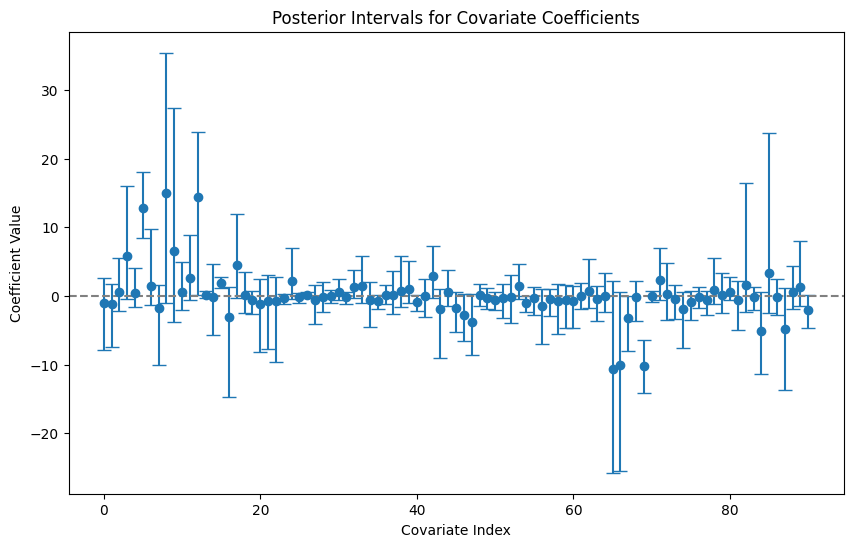

In [30]:
# Posterior samples from betas
beta_samples = posterior_samples['beta']

# Mean and credible intervals for betas
beta_means = jnp.mean(beta_samples, axis=0)
beta_lower = jnp.percentile(beta_samples, 2.5, axis=0)
beta_upper = jnp.percentile(beta_samples, 97.5, axis=0)

# Plot for feature importance
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(beta_means)), beta_means, yerr=[beta_means - beta_lower, beta_upper - beta_means], fmt='o', capsize=5)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Covariate Index')
plt.ylabel('Coefficient Value')
plt.title('Posterior Intervals for Covariate Coefficients')
plt.show()